# Test GEModelTools - HANK

This notebook shows how to **solve a simple Heterogenous Agent New Keynessian (HANK) model** with **endogenous idiosyncratic risk** using the `GEModelTools` package.

**The steps of the sequence-space solution method are:**

1. Find the stationary equilibrium (steady state for aggregates and distribution).
2. Compute Jacobians of the household block and the full model (to unknowns and shocks)
3. Find the non-linear transition path or the linearized impulse responses to a given shock path.
4. Simulate the linearized model with aggregate risk

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from HANKModel import HANKModelClass

# Setup

In [2]:
model = HANKModelClass(name='baseline')

# Steady state

In [3]:
model.find_ss(do_print=True)

steady state found in 12.7 secs
 beta   =   0.9822
 varphi =   0.7864

Discrepancy in B =   0.00000000
Discrepancy in C =   0.00000000
Discrepancy in N =   0.00000000


In [4]:
par = model.par
ss = model.ss
path = model.path

## Policy functions

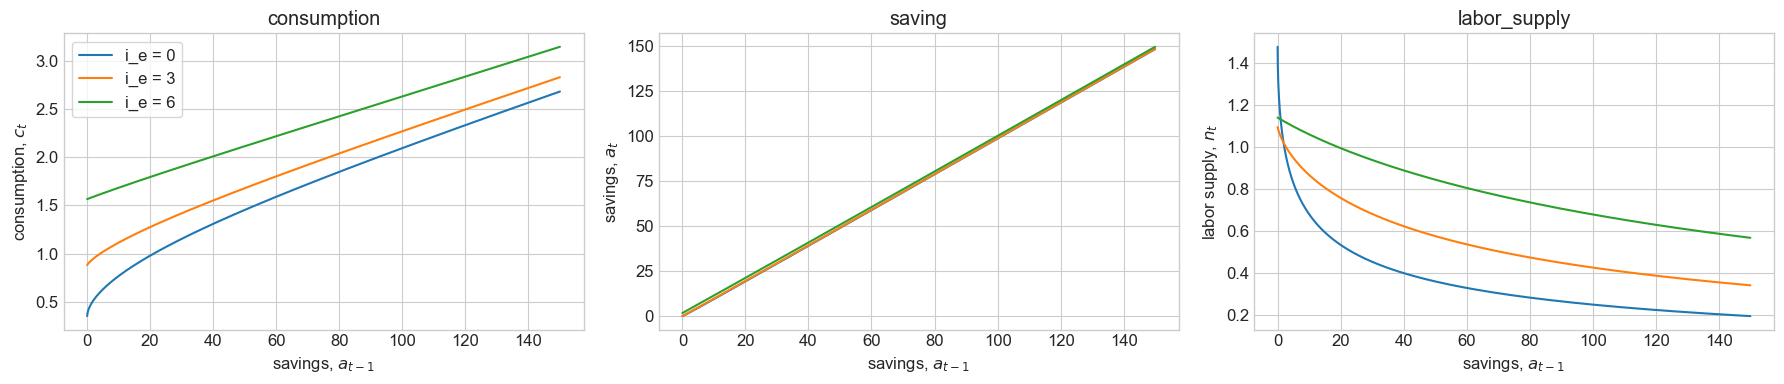

In [5]:
fig = plt.figure(figsize=(18,4),dpi=100)
a_max = 500

# a. consumption
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,1)
ax.set_title(f'consumption')

for i_e in [0,par.Ne//2,par.Ne-1]:
    ax.plot(par.a_grid[I],ss.c[0,i_e,I],label=f'i_e = {i_e}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')

# b. saving
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,2)
ax.set_title(f'saving')

for i_e in [0,par.Ne//2,par.Ne-1]:
    ax.plot(par.a_grid[I],ss.a[0,i_e,I],label=f'i_e = {i_e}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('savings, $a_{t}$')

# c. labor supply
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,3)
ax.set_title(f'labor_supply')

for i_e in [0,par.Ne//2,par.Ne-1]:
    ax.plot(par.a_grid[I],ss.ne[0,i_e,I]/par.z_grid[i_e],label=f'i_e = {i_e}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('labor supply, $n_{t}$')

fig.tight_layout()

## Simulation

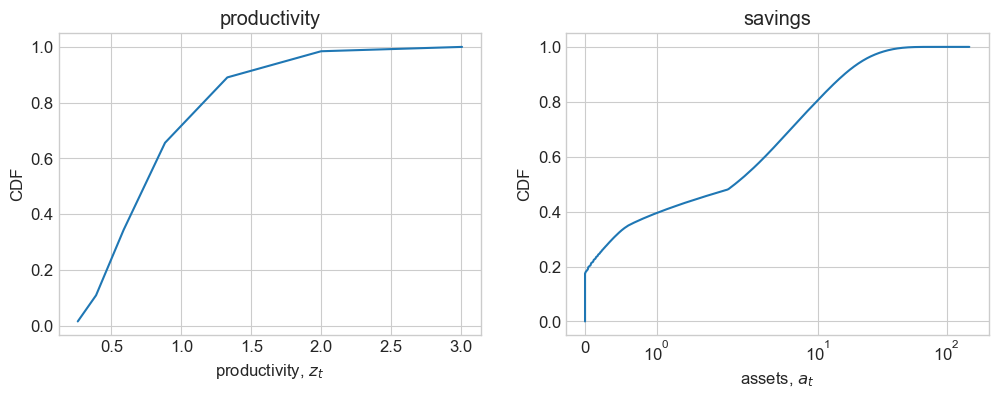

In [6]:
fig = plt.figure(figsize=(12,4),dpi=100)

# a. income
ax = fig.add_subplot(1,2,1)
ax.set_title('productivity')

y = np.cumsum(np.sum(ss.D[0],axis=1))
ax.plot(par.z_grid,y/y[-1])

ax.set_xlabel('productivity, $z_{t}$')
ax.set_ylabel('CDF')

# b. assets
ax = fig.add_subplot(1,2,2)
ax.set_title('savings')
y = np.insert(np.cumsum(np.sum(ss.D[0],axis=0)),0,0.0)
ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),y/y[-1])
        
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')


# Tests

**Household transition path:**

note: inputs = steady state value -> expected: constant value (straigt line)

household problem solved along transition path in 0.5 secs
household problem simulated along transition in 1.4 secs



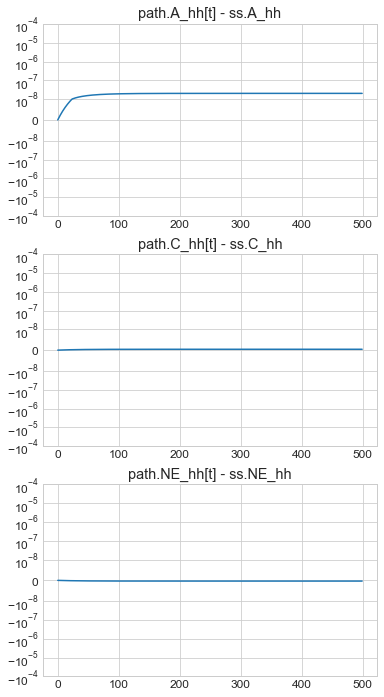

In [7]:
model.test_hh_path()

**Full transition path:**

In [8]:
model.test_path()

note: inputs = steady state value -> expected: no difference to steady state and zero errors

difference to value at steady state:
A_hh           : t0 =  6.9e-13, max abs.  2.0e-08
A              : t0 =  0.0e+00, max abs.  0.0e+00
B              : t0 =  0.0e+00, max abs.  0.0e+00
C_hh           : t0 = -3.6e-13, max abs.  4.2e-10
C              : t0 =  0.0e+00, max abs.  0.0e+00
d              : t0 =  0.0e+00, max abs.  0.0e+00
G              : t0 =  0.0e+00, max abs.  0.0e+00
i              : t0 =  0.0e+00, max abs.  0.0e+00
NE_hh          : t0 =  4.0e-13, max abs.  3.4e-10
NE             : t0 =  0.0e+00, max abs.  0.0e+00
pi             : t0 =  0.0e+00, max abs.  0.0e+00
psi            : t0 =  0.0e+00, max abs.  0.0e+00
r              : t0 = -1.1e-16, max abs.  1.1e-16
istar          : t0 =  0.0e+00, max abs.  0.0e+00
tau            : t0 = -6.0e-16, max abs.  6.0e-16
w              : t0 =  0.0e+00, max abs.  0.0e+00
Y              : t0 =  0.0e+00, max abs.  0.0e+00
Z              : t0

note: differences should only be due to numerical errors

direct method:
finding Jacobian wrt. ghost          : 50 100 150 [computed in 0.7 secs]
finding Jacobian wrt. d              : 50 100 150 [computed in 0.6 secs]
finding Jacobian wrt. r              : 50 100 150 [computed in 0.6 secs]
finding Jacobian wrt. tau            : 50 100 150 [computed in 0.7 secs]
finding Jacobian wrt. w              : 50 100 150 [computed in 0.7 secs]
household Jacobian computed in 3.4 secs

fake news method:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for d               in 0.4 secs
curly_Y and curly_D calculated for r               in 0.5 secs
curly_Y and curly_D calculated for tau             in 0.4 secs
curly_Y and curly_D calculated for w               in 0.5 secs
curly_E calculated in 1.7 secs
builiding blocks combined in 0.3 secs
household Jacobian computed in 3.8 secs

A_hh:
 d              : cond = 2.8e+01 [mean =  7.5e-03]
 r              : cond =

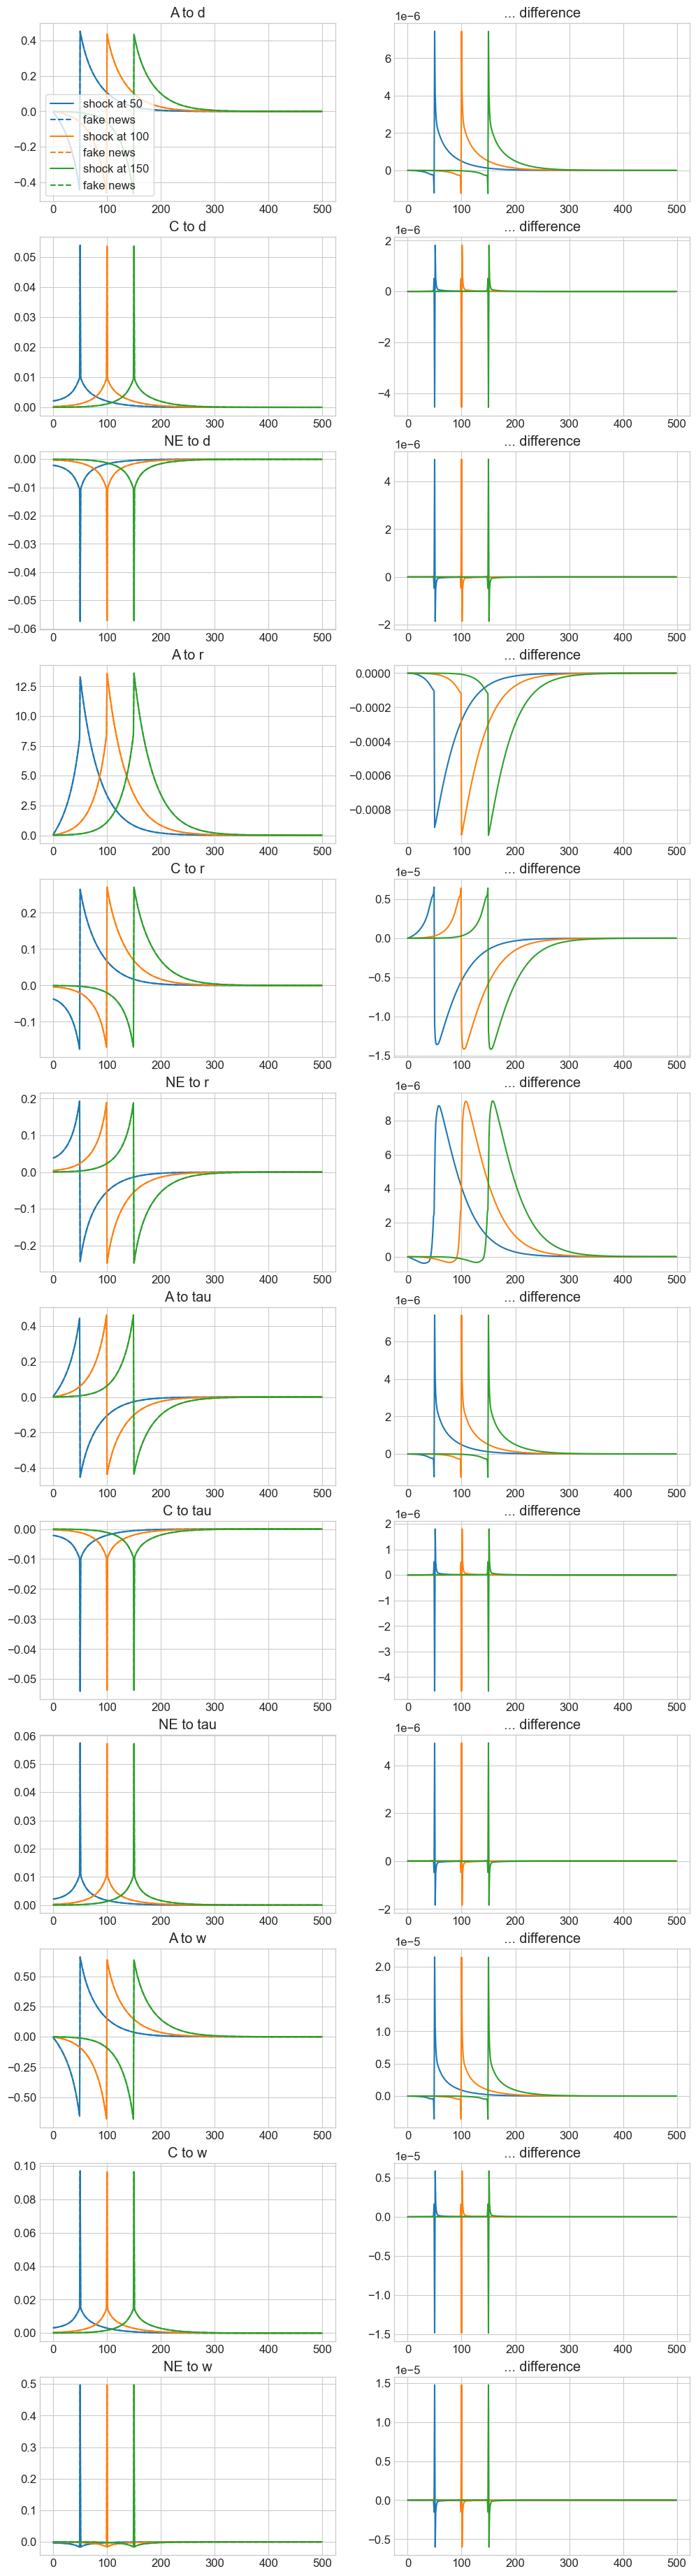

In [9]:
model.test_jac(s_list=[50,100,150])

# Transition path

## Find transition path

In [10]:
par.jump_istar = -0.10/4
model.find_transition_path(do_print=True)

finding the transition path:
 it =   0 -> max. abs. error = 1.41e-01
   0.00e+00 in nkpc_res
   1.41e-01 in clearing_A
   2.68e-02 in clearing_NE
 it =   1 -> max. abs. error = 1.29e-02
   9.51e-05 in nkpc_res
   1.29e-02 in clearing_A
   5.53e-04 in clearing_NE
 it =   2 -> max. abs. error = 7.52e-04
   4.41e-05 in nkpc_res
   6.51e-04 in clearing_A
   7.52e-04 in clearing_NE
 it =   3 -> max. abs. error = 9.71e-05
   3.10e-06 in nkpc_res
   9.71e-05 in clearing_A
   6.81e-05 in clearing_NE
 it =   4 -> max. abs. error = 5.65e-06
   6.25e-07 in nkpc_res
   5.65e-06 in clearing_A
   3.91e-06 in clearing_NE
 it =   5 -> max. abs. error = 1.37e-06
   2.79e-08 in nkpc_res
   1.37e-06 in clearing_A
   4.60e-07 in clearing_NE
 it =   6 -> max. abs. error = 9.23e-08
   2.97e-09 in nkpc_res
   9.23e-08 in clearing_A
   2.85e-08 in clearing_NE
 it =   7 -> max. abs. error = 1.73e-08
   2.53e-10 in nkpc_res
   1.73e-08 in clearing_A
   3.56e-09 in clearing_NE
 it =   8 -> max. abs. error = 1.49

## Plot transitions

### shocks ###


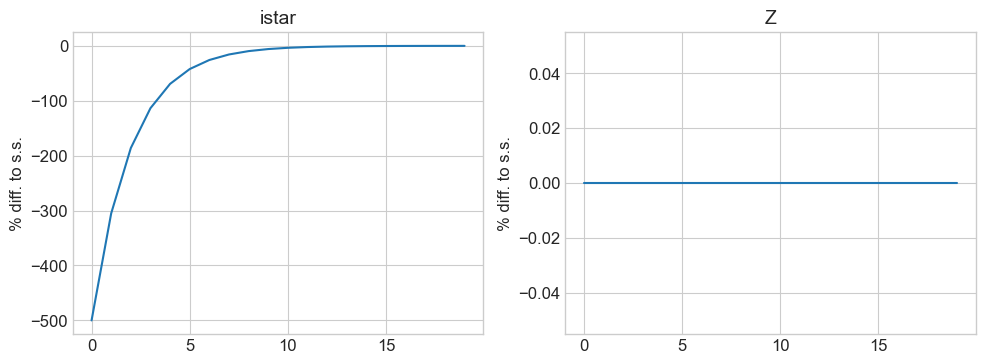


### varnames ###


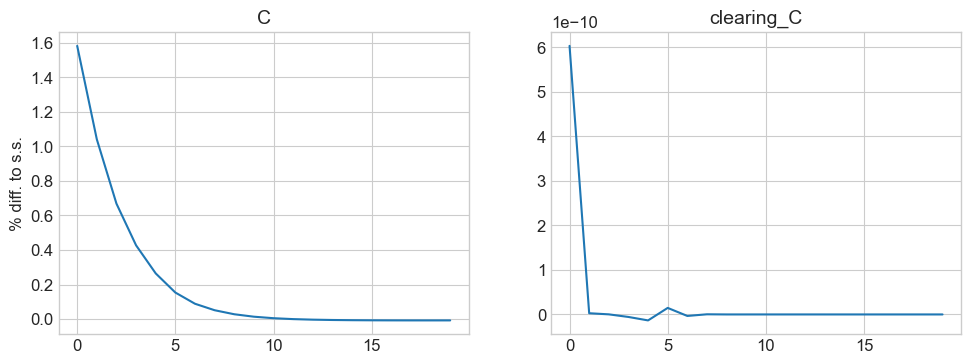


### tagets ###


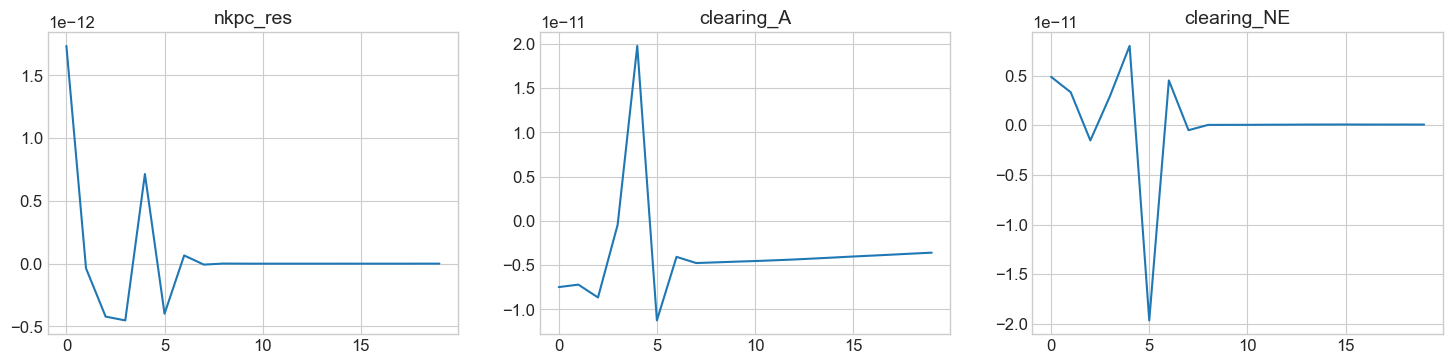

In [11]:
paths = ['C','clearing_C']
model.show_IRFs(paths,T_max=20,ncols=3)

## Linearized

In [12]:
model.find_IRFs(do_print=True)

linear transition path found in 0.1 secs [finding solution matrix: 0.1 secs]


### shocks ###


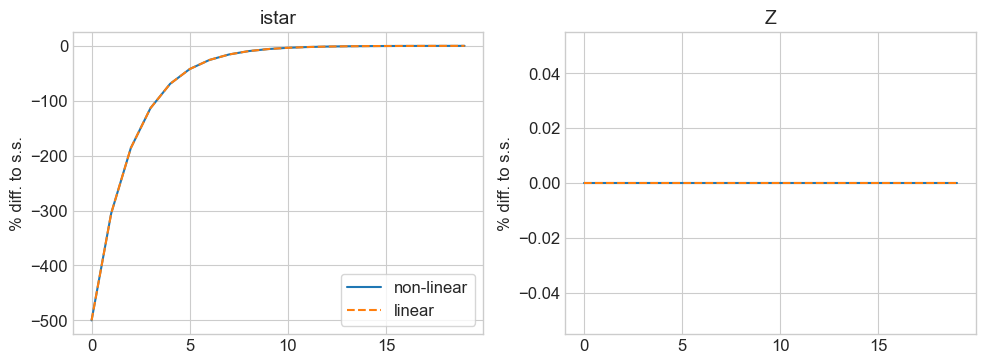


### varnames ###


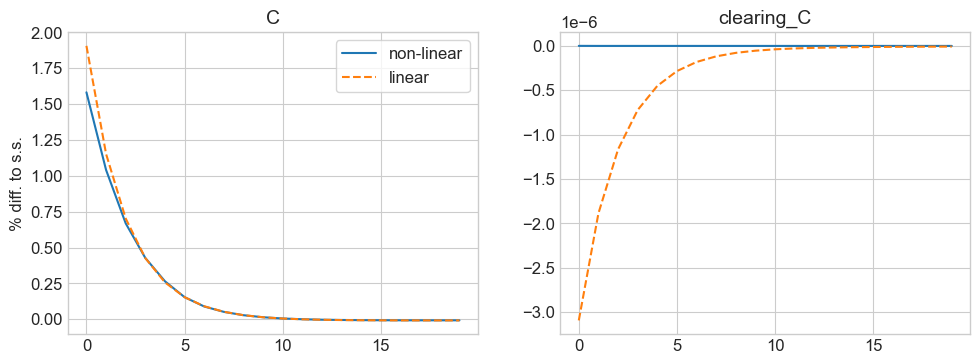


### tagets ###


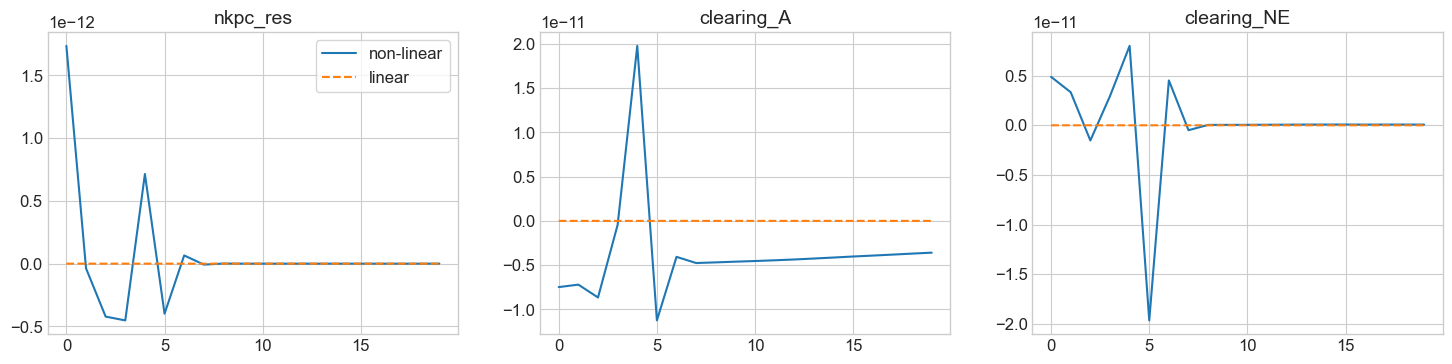

In [13]:
model.show_IRFs(paths,T_max=20,ncols=3,do_linear=True)

# Problem

In [14]:
model_ = model.copy()
model_.par.tau_r_fac = 0.0
model_.find_ss(do_print=True)
model_.compute_jacs(do_print=True)
model_.find_transition_path(do_print=True)

steady state found in 2.8 secs
 beta   =   0.9822
 varphi =   0.7864

Discrepancy in B =  -0.00000000
Discrepancy in C =   0.00000000
Discrepancy in N =  -0.00000000
household Jacobians:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for d               in 0.5 secs
curly_Y and curly_D calculated for r               in 0.4 secs
curly_Y and curly_D calculated for tau             in 0.4 secs
curly_Y and curly_D calculated for w               in 0.5 secs
curly_E calculated in 0.1 secs
builiding blocks combined in 0.3 secs
household Jacobian computed in 2.2 secs

full Jacobians:
full Jacobian to unknowns computed in 0.9 secs [in evaluate_path(): 0.5 secs]
full Jacobian to shocks computed in 0.7 secs [in evaluate_path(): 0.4 secs]
finding the transition path:
 it =   0 -> max. abs. error = 3.71e-01
   0.00e+00 in nkpc_res
   3.71e-01 in clearing_A
   2.04e-02 in clearing_NE
backtracking...
backtracking...
backtracking...
backtracking...
backtrackin

ValueError: GEModelTools: Number of backtracks exceeds 30